Uvoz knjižnic in branje podatkov iz datotek:

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import operator

In [ ]:
list_of_cvs = ["./podatki/kd{}.csv".format(i) for i in range(2010,2020)]
frames = [pd.read_csv(csv,sep=';', encoding="UTF-8", dtype={'MesecStoritve': str}) for csv in list_of_cvs]
df = pd.concat(frames)

In [3]:
dfGroupedBySex = df.groupby(["Spol"]);

In [4]:
# { sex: {year: count} }
crimesBySex = {};
for sex, bySexData in dfGroupedBySex:
    if(sex not in crimesBySex):
        crimesBySex[sex] = defaultdict(int);
    for yearStr in bySexData["MesecStoritve"].values:
        year = int(yearStr.split(".")[1]);
        crimesBySex[sex][year] += 1;
#print(crimesBySex);

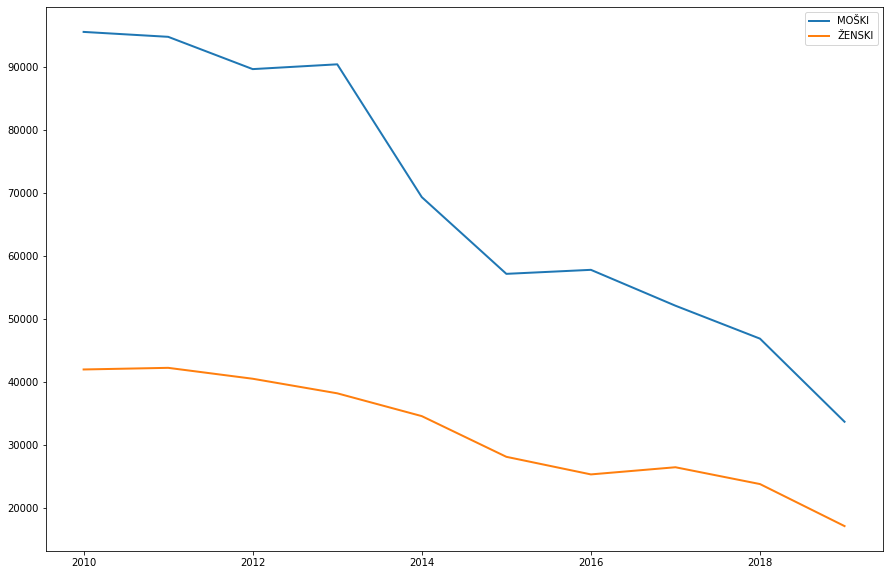

In [5]:
plt.figure(figsize=(15,10));
for sex, crimesPerYear in crimesBySex.items():
    if(sex != "MOŠKI" and sex != "ŽENSKI"):
        continue;
    sortedYears = [ year for year in sorted(crimesPerYear.keys()) if(2010 <= year < 2020) ];
    crimesPerSortedYear = [ crimesPerYear[year] for year in sortedYears ];
    plt.plot(sortedYears, crimesPerSortedYear, label=sex, linewidth=2.0);
plt.legend();

Kazniva dejanja po letih:

In [ ]:
#group by mesec, count unique id
kd_leto = df.groupby(['MesecStoritve', 'UraStoritve','ZaporednaStevilkaKD'])
leto_counter = defaultdict(int)

for name,v in kd_leto:
    index = int((name[0].split(".")[1]))
    if index >= 2010 and index < 2020:
        leto_counter[index] +=1
    
    
list_mes_counter = sorted(leto_counter.items())
mesec, counter = zip(*list_mes_counter)
plt.figure(figsize=(15,10))
plt.plot(mesec,counter)
plt.show()

Porazdelitev kaznivih dejanj po mesecih:

In [ ]:
kd_mes = df.groupby(['MesecStoritve', 'UraStoritve','ZaporednaStevilkaKD'])
mes_counter = defaultdict(int)

for name,v in kd_mes:
    index = int((name[0].split(".")[0]))
    mes_counter[index] +=1


list_mes_counter = sorted(mes_counter.items())
mesec, counter = zip(*list_mes_counter)
plt.figure(figsize=(15,10))
plt.bar(mesec,counter)
plt.show()

Udeleženci v kaznivih dejanjih porazdeljeni po starostnih razredih:

In [ ]:
star_razredi = df.groupby(['StarostniRazred'])
star_razred, star_stevilo = zip(*[(name,razred.size) for name, razred in star_razredi])

star_stevilo = list(star_stevilo)
star_stevilo[-3] += star_stevilo[-2]

plt.figure(figsize=(15,10))
plt.bar(star_razred[:-2],star_stevilo[:-2])
plt.show()
#plt.pie(star_stevilo[:-3], labels=star_razred[:-3])

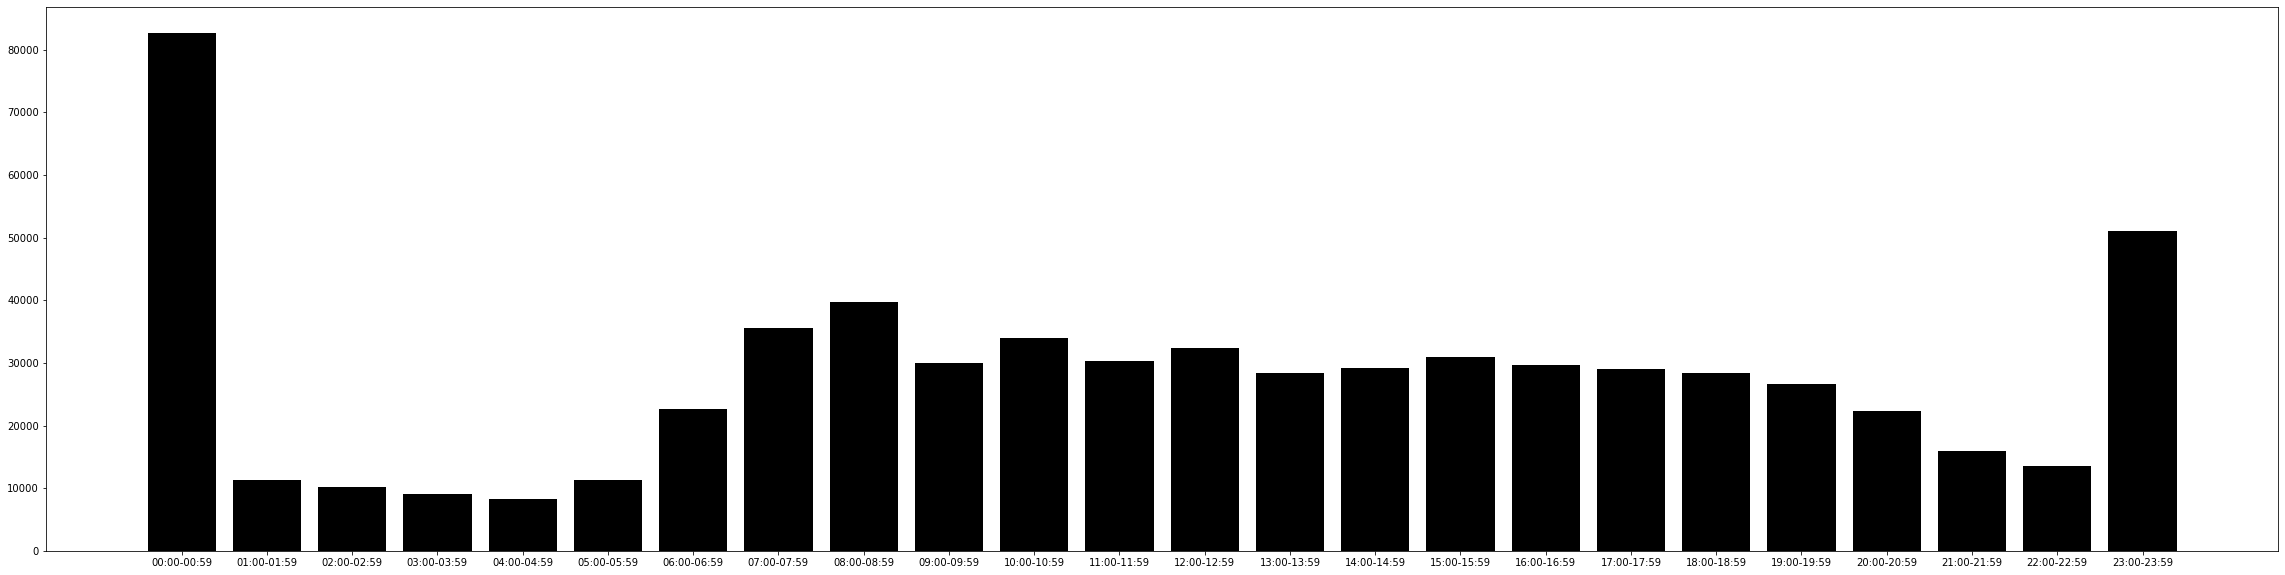

In [46]:
#group by mesec, count unique id
kd_ura = df.groupby(['UraStoritve', 'ZaporednaStevilkaKD'])
ura_counter = defaultdict(int)

for name,v in kd_ura:
    ura_counter[name[0]] += 1


list_ura_counter = sorted(ura_counter.items())
ura, counter = zip(*list_ura_counter)
plt.figure(figsize=(40,10))
plt.bar(ura,counter, color="black")
plt.show()